In [9]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [34]:
%%appyter markdown

<center> <h1> <img src="{{ url_for('static', filename='cluster-icon.svg') }}" style="height:45px;padding:0 10px 10px 0;display:inline"/> Patient Cohorts RNA-Seq Viewer</h1>
<h3>An appyter for the visualization and analysis of intra-cancer patient clusters based on RNA-Seq profiles and clinical data</h3></center>


<center> <h1> <img src="static/cluster-icon.svg" style="height:45px;padding:0 10px 10px 0;display:inline"/> Patient Cohorts RNA-Seq Viewer</h1>
<h3>An appyter for the visualization and analysis of intra-cancer patient clusters based on RNA-Seq profiles and clinical data</h3></center>

---
By default, we use TCGA data. Users can optionally also upload their own datasets.

Each column in the RNA-Seq dataset corresponds to a row in the clinical dataset; both are referenced by the same identifier (here the `case_id` as provided by TCGA). 

The RNA-Seq data loaded from TCGA is in the form of raw counts mapped to genes with the HT-Seq Counts analysis package. We then filter for the most variable genes, normalize those counts, and reduce the dimensionality of the dataset further with PCA and UMAP.

To determine the ideal number of clusters, we probe a range and select the number based on a modified silhouette score that prioritizes more clusters (so we do not miss out on small clusters).

We identify the top genes for each cluster, using these for Enrichment analysis and treatment suggestion based on the drugs used for perurbation to produce signatures most opposite to each cluster in the L1000 dataset.

### Table of Contents:
1. [Import dataset](#import)
2. [Process data and compute clusters](#processing)
3. [Load Enrichr Data](#enrichr)
4. [Load L1000 Data](#l1000)

In [132]:
import os
import numpy as np
import pandas as pd
import requests
import time
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import math
from collections import OrderedDict
import json
from jupyter_d3 import scatter_plot
from IPython.display import display, IFrame, Markdown, HTML
from textwrap import wrap

In [39]:
%%appyter hide_code

{% do SectionField(
    name="DATASET",
    title="Dataset selection",
    subtitle='If using TCGA data, leave both file upload fields blank and simply select the desired cancer type.',
    img = "tcga-logo.png"
) %}


{% do SectionField(
    name='CONFIG',
    title='Analysis parameters',
    subtitle='Select various parameters for dimensionality reduction and dataset size. Defaults for n_neighbors and min_cluster_dist are based on the defaults used by the Seurat R Package for single cell genomics analysis.',
    img = "parameters-icon.svg"

) %}

{% do SectionField(
    name="ENRICHR_LIBS",
    title="Libraries to include in the Enrichr search",
    img = "enrichr-logo.png"
) %}

{% do SectionField(
    name="L1000FWD",
    title="L1000FWD search parameters",
    img = "l1000fwd.png"
) %}



UsageError: Cell magic `%%appyter` not found.


In [116]:
%%appyter code_eval

data_filename = '''{{ FileField(
    name='data_filename', 
    label='RNA-seq data file (.csv)', 
    description='Upload RNA-seq dataset in csv format. The index of the dataset are genes, the columns are samples.', 
    default='',
    section='DATASET'
) }}'''

clinical_data_filename = '''{{ FileField(
    name='clinical_data_filename', 
    label='Clinical data file (.csv)', 
    description='Upload clinical data in csv format. The first column should contain patient IDs corresponding to those in the RNA-seq file. Each subsequent column is a clinical data field.', 
    default='',
    section='DATASET'
) }}'''

cancer = '''{{ ChoiceField(
        name = "cancer",
        label = "Cancer type",
        description="The value provided as the primary diagnosis on cases in TCGA.",
        choices=["Infiltrating duct carcinoma, NOS","Squamous cell carcinoma, NOS","Lobular carcinoma, NOS","Acute myeloid leukemia, NOS","Hepatocellular carcinoma, NOS","Serous cystadenocarcinoma, NOS","Endometrioid adenocarcinoma, NOS","Adenocarcinoma, NOS","Clear cell adenocarcinoma, NOS","Glioblastoma","Mucinous adenocarcinoma","Transitional cell carcinoma","Malignant melanoma, NOS","Papillary adenocarcinoma, NOS"],
        section="DATASET",
        default="Serous cystadenocarcinoma, NOS" 
) }}'''
    
n_pca_components = {{ IntField(
    name='n_pca_components',
    label='Number of PCA components to use for UMAP',
    default=10,
    min=0,
    max=100,
    section='CONFIG',
) }}

n_neighbors = {{ IntField(
    name='n_neighbors',
    label='Number of neighbors for each projected datapoint computed by UMAP',
    description='Smaller values preserve local manifold structure in the dataset as opposed to overall global structure',
    default=40,
    min=2,
    max=200,
    section='CONFIG',
) }}

min_cluster_dist = {{ FloatField(
    name='min_cluster_dist',
    label='Minimum distance between UMAP-projected points',
    description='How tightly packed points produced by dimensionality reduction with UMAP are permitted to be.',
    default=0.3,
    min=0.1,
    max=1,
    section='CONFIG',
) }}

top_n_genes = {{ IntField(
    name='top_n_genes',
    label='Number of top most variable genes to analyze',
    description='The number of \'top\' most variable genes to use for analysis',
    default=2500,
    min=100,
    max=19000,
    section='CONFIG',
) }}

top_n_genes_enrichment = {{ IntField(
    name='top_n_genes_enrichment',
    label='Number of top genes to use for enrichment analysis',
    description='The number of \'top\' genes to use for enrichment analysis',
    default=250,
    min=100,
    max=1000,
    section='CONFIG',
) }}

heatmap_top_n = {{ IntField(
    name='cluster_top_n',
    label='Number of up and down genes per cluster for heatmap visualizatiton',
    default=100,
    min=100,
    max=1000,
    section='CONFIG',
) }}

top_n_results = {{ IntField(
    name='top_n_results',
    label='Number of top enrichment results',
    default=5,
    min=1,
    max=100,
    section='CONFIG',
) }}

use_default_libraries = {{BoolField(
    name="use_default_libraries",
    label="Use default Enrichr libraries?",
    description = "The default libraries include:\nKEGG_2019_Human,\nKEGG_2019_Mouse,\nGO_Biological_Process_2018,\nMGI_Mammalian_Phenotype_Level_4_2019,\nGWAS_Catalog_2019,\nENCODE_TF_ChIP-seq_2015.",
    default = False,
    section = 'ENRICHR_LIBS'
)}}


transcription_libraries = {{MultiChoiceField(name='transcription_libraries', 
                                            label='Transcription',
                                            default=[], 
                                            section = 'ENRICHR_LIBS',
                                            choices=[
                                                'ARCHS4_TFs_Coexp',
                                                'ChEA_2016',
                                                'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
                                                'ENCODE_Histone_Modifications_2015',
                                                'ENCODE_TF_ChIP-seq_2015',
                                                'Epigenomics_Roadmap_HM_ChIP-seq',
                                                'Enrichr_Submissions_TF-Gene_Coocurrence',
                                                'Genome_Browser_PWMs',
                                                'lncHUB_lncRNA_Co-Expression',
                                                'miRTarBase_2017',
                                                'TargetScan_microRNA_2017',
                                                'TF-LOF_Expression_from_GEO',
                                                'TF_Perturbations_Followed_by_Expression',
                                                'Transcription_Factor_PPIs',
                                                'TRANSFAC_and_JASPAR_PWMs',
                                                'TRRUST_Transcription_Factors_2019'
                                            ])  }}

pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', 
                                         label='Pathways', 
                                         default=[], 
                                         section='ENRICHR_LIBS',
                                         choices=[
                                                    'ARCHS4_Kinases_Coexp',
                                                    'BioCarta_2016',
                                                    'BioPlanet_2019',
                                                    'BioPlex_2017',
                                                    'CORUM',
                                                    'Elsevier_Pathway_Collection',
                                                    'HMS_LINCS_KinomeScan',
                                                    'HumanCyc_2016',
                                                    'huMAP',
                                                    'KEA_2015',
                                                    'KEGG_2019_Human',
                                                    'KEGG_2019_Mouse',
                                                    'Kinase_Perturbations_from_GEO_down',
                                                    'Kinase_Perturbations_from_GEO_up',
                                                    'L1000_Kinase_and_GPCR_Perturbations_down',
                                                    'L1000_Kinase_and_GPCR_Perturbations_up',
                                                    'NCI-Nature_2016',
                                                    'NURSA_Human_Endogenous_Complexome',
                                                    'Panther_2016',
                                                    'Phosphatase_Substrates_from_DEPOD',
                                                    'PPI_Hub_Proteins',
                                                    'Reactome_2016',
                                                    'SILAC_Phosphoproteomics',
                                                    'SubCell_BarCode',
                                                    'Virus-Host_PPI_P-HIPSTer_2020',
                                                    'WikiPathways_2019_Human',
                                                    'WikiPathways_2019_Mouse']) }}

ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', 
                                           label='Ontologies', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[
                                                'GO_Biological_Process_2018',
                                                'GO_Cellular_Component_2018',
                                                'GO_Molecular_Function_2018',
                                                'Human_Phenotype_Ontology',
                                                'Jensen_COMPARTMENTS',
                                                'Jensen_DISEASES',
                                                'Jensen_TISSUES',
                                                'MGI_Mammalian_Phenotype_Level_4_2019'
                                           ])  }}
    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', 
                                               label='Diseases/Drugs', 
                                               default=[], 
                                               section = 'ENRICHR_LIBS',
                                               choices=[    
                                                    'Achilles_fitness_decrease',
                                                    'Achilles_fitness_increase',
                                                    'ARCHS4_IDG_Coexp',
                                                    'ClinVar_2019',
                                                    'dbGaP',
                                                    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
                                                    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
                                                    'DisGeNET',
                                                    'DrugMatrix',
                                                    'DSigDB',
                                                    'GeneSigDB',
                                                    'GWAS_Catalog_2019',
                                                    'LINCS_L1000_Chem_Pert_down',
                                                    'LINCS_L1000_Chem_Pert_up',
                                                    'LINCS_L1000_Ligand_Perturbations_down',
                                                    'LINCS_L1000_Ligand_Perturbations_up',
                                                    'MSigDB_Computational',
                                                    'MSigDB_Oncogenic_Signatures',
                                                    'Old_CMAP_down',
                                                    'Old_CMAP_up',
                                                    'OMIM_Disease',
                                                    'OMIM_Expanded',
                                                    'PheWeb_2019',
                                                    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_AutoRIF_Gene_Lists',
                                                    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_GeneRIF_Gene_Lists',
                                                    'UK_Biobank_GWAS_v1',
                                                    'Virus_Perturbations_from_GEO_down',
                                                    'Virus_Perturbations_from_GEO_up',
                                                    'VirusMINT']) }}
    
cell_types_libraries = {{ MultiChoiceField(name='cell_types_libraries', 
                                           label='Cell Types', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[        
                                                'Allen_Brain_Atlas_down',
                                                'Allen_Brain_Atlas_up',
                                                'ARCHS4_Cell-lines',
                                                'ARCHS4_Tissues',
                                                'Cancer_Cell_Line_Encyclopedia',
                                                'CCLE_Proteomics_2020',
                                                'ESCAPE',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_down',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_up',
                                                'Human_Gene_Atlas',
                                                'Mouse_Gene_Atlas',
                                                'NCI-60_Cancer_Cell_Lines',
                                                'ProteomicsDB_2020',
                                                'Tissue_Protein_Expression_from_Human_Proteome_Map']) }}
    
    
miscellaneous_libraries = {{ MultiChoiceField(name='miscellaneous_libraries', 
                                              label='Miscellaneous', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[            
                                                    'Chromosome_Location_hg19',
                                                    'Data_Acquisition_Method_Most_Popular_Genes',
                                                    'Enrichr_Libraries_Most_Popular_Genes',
                                                    'Genes_Associated_with_NIH_Grants',
                                                    'HMDB_Metabolites',
                                                    'HomoloGene',
                                                    'InterPro_Domains_2019',
                                                    'NIH_Funded_PIs_2017_AutoRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_Human_AutoRIF',
                                                    'NIH_Funded_PIs_2017_Human_GeneRIF',
                                                    'Pfam_Domains_2019',
                                                    'Pfam_InterPro_Domains',
                                                    'Table_Mining_of_CRISPR_Studies'])  }}
    
    
legacy_libraries = {{ MultiChoiceField(name='legacy_libraries', 
                                       label='Legacy', 
                                       default=[], 
                                       section = 'ENRICHR_LIBS',
                                       choices=[                
                                            'BioCarta_2013',
                                            'BioCarta_2015',
                                            'ChEA_2013',
                                            'ChEA_2015',
                                            'Chromosome_Location',
                                            'Disease_Signatures_from_GEO_down_2014',
                                            'Disease_Signatures_from_GEO_up_2014',
                                            'Drug_Perturbations_from_GEO_2014',
                                            'ENCODE_Histone_Modifications_2013',
                                            'ENCODE_TF_ChIP-seq_2014',
                                            'GO_Biological_Process_2013',
                                            'GO_Biological_Process_2015',
                                            'GO_Biological_Process_2017',
                                            'GO_Biological_Process_2017b',
                                            'GO_Cellular_Component_2013',
                                            'GO_Cellular_Component_2015',
                                            'GO_Cellular_Component_2017',
                                            'GO_Cellular_Component_2017b',
                                            'GO_Molecular_Function_2013',
                                            'GO_Molecular_Function_2015',
                                            'GO_Molecular_Function_2017',
                                            'GO_Molecular_Function_2017b',
                                            'HumanCyc_2015',
                                            'KEA_2013',
                                            'KEGG_2013',
                                            'KEGG_2015',
                                            'KEGG_2016',
                                            'MGI_Mammalian_Phenotype_2013',
                                            'MGI_Mammalian_Phenotype_2017',
                                            'MGI_Mammalian_Phenotype_Level_3',
                                            'MGI_Mammalian_Phenotype_Level_4',
                                            'NCI-Nature_2015',
                                            'Panther_2015',
                                            'Reactome_2013',
                                            'Reactome_2015',
                                            'TargetScan_microRNA',
                                            'Tissue_Protein_Expression_from_ProteomicsDB',
                                            'WikiPathways_2013',
                                            'WikiPathways_2015',
                                            'WikiPathways_2016']) }}

crowd_libraries = {{ MultiChoiceField(name='crowd_libraries', 
                                      label='Crowd', 
                                      default=[],
                                      section = 'ENRICHR_LIBS',
                                      choices=[                
                                            'Aging_Perturbations_from_GEO_down',
                                            'Aging_Perturbations_from_GEO_up',
                                            'Disease_Perturbations_from_GEO_down',
                                            'Disease_Perturbations_from_GEO_up',
                                            'Drug_Perturbations_from_GEO_down',
                                            'Drug_Perturbations_from_GEO_up',
                                            'Gene_Perturbations_from_GEO_down',
                                            'Gene_Perturbations_from_GEO_up',
                                            'Ligand_Perturbations_from_GEO_down',
                                            'Ligand_Perturbations_from_GEO_up',
                                            'MCF7_Perturbations_from_GEO_down',
                                            'MCF7_Perturbations_from_GEO_up',
                                            'Microbe_Perturbations_from_GEO_down',
                                            'Microbe_Perturbations_from_GEO_up',
                                            'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                                            'SysMyo_Muscle_Gene_Sets']) }}



top_n_drugs = {{IntField(
    name='top_n_drugs',
    label='Number of top drug treatments to suggest for each cluster',
    default=5,
    min=0,
    max=50,
    section='L1000FWD',
) }}

default_libraries = OrderedDict([
    ('Diseases/Drugs', ['GWAS_Catalog_2019']), 
    ('Ontologies', ['GO_Biological_Process_2018','MGI_Mammalian_Phenotype_Level_4_2019']),
    ('Pathways', ['KEGG_2019_Human','KEGG_2019_Mouse']),
    ('Transcription', ['ENCODE_TF_ChIP-seq_2015']),
])

if use_default_libraries:
    enrichr_libraries = default_libraries
else: 
    enrichr_libraries = OrderedDict([
        ('Diseases/Drugs', diseases_drugs_libraries), 
        ('Ontologies', ontologies_libraries),
        ('Cell Type', cell_types_libraries),
        ('Pathways', pathways_libraries),
        ('Transcription', transcription_libraries),
        ('Legacy', legacy_libraries),
        ('Crowd', crowd_libraries)
    ])

    all_empty = True
    for key,libs in enrichr_libraries.items():
        if len(libs) > 0:
            all_empty = False
            break
    if all_empty:
        enrichr_libraries = default_libraries




```python
data_filename = ''''''''
clinical_data_filename = ''''''''
cancer = '''Serous cystadenocarcinoma, NOS'''
n_pca_components = 10
n_neighbors = 40
min_cluster_dist = 0.3
top_n_genes = 2500
top_n_genes_enrichment = 250
heatmap_top_n = 100
top_n_results = 5
use_default_libraries = False
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
cell_types_libraries = []
miscellaneous_libraries = []
legacy_libraries = []
crowd_libraries = []
top_n_drugs = 5
default_libraries = OrderedDict([
    ('Diseases/Drugs', ['GWAS_Catalog_2019']),
    ('Ontologies', ['GO_Biological_Process_2018','MGI_Mammalian_Phenotype_Level_4_2019']),
    ('Pathways', ['KEGG_2019_Human','KEGG_2019_Mouse']),
    ('Transcription', ['ENCODE_TF_ChIP-seq_2015']),
])
if use_default_libraries:
    enrichr_libraries = default_libraries
else:
    enrichr_libraries = OrderedDict([
        ('Diseases/Drugs', diseases_drugs_libraries),
        ('Ontologies', ontologies_libraries),
        ('Cell Type', cell_types_libraries),
        ('Pathways', pathways_libraries),
        ('Transcription', transcription_libraries),
        ('Legacy', legacy_libraries),
        ('Crowd', crowd_libraries)
    ])
    all_empty = True
    for k,v in enrichr_libraries:
        if len(v) > 0:
            all_empty = False
            break
    if all_empty:
        enrichr_libraries = default_libraries
```

# 1. Import dataset <a class="anchor" id="import"></a>

If using user-uploaded data, we access those files and set the necessary index names.

Otherwise, we first download the data containing RNA-seq profiles for the selected cancer type from TCGA and the corresponding clinical data for those cases.

The RNA-seq data that is provided has already been processed using the HTSeq Python package, which calculates the number of mapped reads to each gene.

In [40]:
%%appyter hide_code

# Utility function for saving the dataset
def save_data(cancer_type,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs):
    
    # create the root dir
    root_dir = f'./processed_data/{cancer_type}'
    os.makedirs(root_dir, exist_ok=True)

    # /clustering/graphclust/clusters.csv
    #   Barcode,Cluster
    os.makedirs(f'{root_dir}/clustering/graphclust', exist_ok=True)
    df_data_norm_km.to_csv(f'{root_dir}/clustering/graphclust/clusters.csv')
    
    # /pca/10_components/projection.csv
    #   Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
    os.makedirs(f'{root_dir}/pca/{n_pca_components}_components', exist_ok=True)
    df_data_norm_pca.to_csv(f'{root_dir}/pca/{n_pca_components}_components/projection.csv')
    
    # /umap/2_components/projection.csv
    #   Barcode,UMAP-1,UMAP-2
    os.makedirs(f'{root_dir}/umap/2_components', exist_ok=True)
    df_data_norm_umap.to_csv(f'{root_dir}/umap/2_components/projection.csv')
    
     # /diffexp/graphclust/differential_expression.csv
    #   Feature Name,Cluster 2 Log2 fold change,Cluster 0 Log2 fold change,Cluster 1 Log2 fold change,Cluster 3 Log2 fold change,Cluster 2 Adjusted p value,Cluster 0 Adjusted p value,Cluster 1 Adjusted p value,Cluster 3 Adjusted p value,Cluster 2 Mean Counts,Cluster 0 Mean Counts,Cluster 1 Mean Counts,Cluster 3 Mean Counts,Feature Name
    os.makedirs(f'{root_dir}/diffexp/graphclust', exist_ok=True)
    df_diff_expr.to_csv(f'{root_dir}/diffexp/graphclust/differential_expression.csv')
    
    # /cluster_aucs.csv
    #   ,2,0,1,3
    df_aucs.to_csv(f'{root_dir}/cluster_aucs.csv')

```python
# Utility function for saving the dataset
def save_data(cancer_type,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs):
    # create the root dir
    root_dir = f'./processed_data/{cancer_type}'
    os.makedirs(root_dir, exist_ok=True)
    # /clustering/graphclust/clusters.csv
    #   Barcode,Cluster
    os.makedirs(f'{root_dir}/clustering/graphclust', exist_ok=True)
    df_data_norm_km.to_csv(f'{root_dir}/clustering/graphclust/clusters.csv')
    # /pca/10_components/projection.csv
    #   Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
    os.makedirs(f'{root_dir}/pca/{n_pca_components}_components', exist_ok=True)
    df_data_norm_pca.to_csv(f'{root_dir}/pca/{n_pca_components}_components/projection.csv')
    # /umap/2_components/projection.csv
    #   Barcode,UMAP-1,UMAP-2
    os.makedirs(f'{root_dir}/umap/2_components', exist_ok=True)
    df_data_norm_umap.to_csv(f'{root_dir}/umap/2_components/projection.csv')
     # /diffexp/graphclust/differential_expression.csv
    #   Feature Name,Cluster 2 Log2 fold change,Cluster 0 Log2 fold change,Cluster 1 Log2 fold change,Cluster 3 Log2 fold change,Cluster 2 Adjusted p value,Cluster 0 Adjusted p value,Cluster 1 Adjusted p value,Cluster 3 Adjusted p value,Cluster 2 Mean Counts,Cluster 0 Mean Counts,Cluster 1 Mean Counts,Cluster 3 Mean Counts,Feature Name
    os.makedirs(f'{root_dir}/diffexp/graphclust', exist_ok=True)
    df_diff_expr.to_csv(f'{root_dir}/diffexp/graphclust/differential_expression.csv')
    # /cluster_aucs.csv
    #   ,2,0,1,3
    df_aucs.to_csv(f'{root_dir}/cluster_aucs.csv')
```

In [121]:
# Notebook display util functions

def download_button(content, label, filename):
    # Add download button
    outname = filename.split('.')[0]
    display(HTML('<textarea id="textbox_{outname}" style="display: none;">{content}</textarea> <button style="margin:10px 0;" id="create_{outname}">{label}</button> <a download="{filename}" id="downloadlink_{outname}" style="display: none">Download</a>'.format(**locals())))
    display(HTML('<script type="text/javascript">!function(){{var e=null,t=document.getElementById("create_{outname}"),n=document.getElementById("textbox_{outname}");t.addEventListener("click",function(){{var t,l,c=document.getElementById("downloadlink_{outname}");c.href=(t=n.value,l=new Blob([t],{{type:"text/plain"}}),null!==e&&window.URL.revokeObjectURL(e),e=window.URL.createObjectURL(l)),c.click()}},!1)}}();</script>'.format(**locals())))

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

In [122]:
user_data = False
if (data_filename != "" and clinical_data_filename != ""): user_data = True

In [123]:
data_index = "symbol"
clinical_index = "case_id"

if user_data:
    df_data = pd.read_csv(data_filename, index_col=0).sort_index()
    df_clinical = pd.read_csv(clinical_data_filename, index_col=0).sort_index()

    df_data.index.name = "symbol"
    df_clinical.index.name = "case_id"
    
else:
    print(f"Loading data for patients diagnosed with {cancer}...\n")
    
    # Import the RNA-seq and clinical DataFrames with only entries corresponding to
    # the selected cancer type
    aws_url = f'https://tcga-enrichr-viewer.s3.amazonaws.com/{cancer.replace(" ", "%20")}'

    df_data = pd.read_csv(f'{aws_url}_data.csv')
    df_data = df_data.set_index("symbol") 

    df_clinical = pd.read_csv(f'{aws_url}_clinical_data.csv')
    df_clinical = df_clinical.set_index("case_id")
    df_clinical = df_clinical.replace("not reported", np.nan)
    
    print("Data loaded")

display(df_data.head())
    


Loading data for patients diagnosed with Serous cystadenocarcinoma, NOS...

Data loaded


,54ac877a-52ff-450c-9df9-b7cd3fc8e2e2,16e69011-c295-479f-b521-86e66fba498d,b60f22ac-a659-4f33-b01d-820e86a9a5c9,3bce9803-e74c-462e-bd40-8ec337a66f3a,1a094c2b-9fba-4bb1-929d-bb2cdf874bee,2b14123b-8fcd-402c-9399-4e7c47f20252,f58e49fc-9641-4b46-be4c-766445ec70a3,6a1be87b-c4e0-4fd4-b050-50a245b22038,24118b8f-59fe-482a-aed3-7b1bde1571b7,7413c891-f74e-456f-bc70-69c83fb53c70,...,0d23fa5b-95f8-4626-a4d2-c72ad3cc553b,4160e048-f0b0-40f5-805b-e277a5893a3b,0a2d29de-869a-4dc8-ad11-6ee0d0a3a895,b8023162-5e82-40e6-ad8c-8acf81821f01,eec69ea9-ceb8-456a-aff4-41fb8a261e36,5503b3a1-7d03-41b2-9ec8-e478c5414d67,79fd602b-3e8e-4353-aa78-4f5f170b607d,07a859fc-6f78-4905-9035-90e2403dbe8d,f9c835db-2ab6-4bf5-826f-48723493c0ec,a782352e-c4bb-4c3e-ba82-456a47c3689a
symbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,1005,1234,11822,2648,3139,1928,2221,13405,2025,7594,...,3071,4105,3007,6136,8602,4884,2830,5286,3635,4420
TNMD,2,0,10,7,4,3,1,2,2,6,...,2,3,0,8,32,2,3,4,3,0
DPM1,232,449,2021,2047,1090,1863,2849,6176,663,3590,...,1399,3706,2297,2954,3094,5054,1045,3846,5822,4038
SCYL3,115,356,1157,453,404,651,695,1060,315,1410,...,759,653,975,1194,1407,890,718,981,1033,978
C1orf112,10,209,1421,412,209,537,448,693,226,634,...,201,419,777,740,1525,626,198,753,915,724


In [124]:
# Get a list of the clinical features with multiple unique values
def has_unique_values(feature):
    unique = df_clinical[feature].dropna().unique()
    if len(unique) >= 1: return True
    return False

icd10_code_map = {}

# map icd10 code field to include semantic description of that code   
def map_icd10_code(code):
    # check the dictionary if we've already requested this code
    if code in icd10_code_map:
        return icd10_code_map[code]
    # otherwise, make the request to the api
    try:
        response = requests.get(f"http://www.icd10api.com/?code={code}")
        try: 
            desc = response.json()["Description"]
            icd10_code_map[code] = desc
            return desc
        except KeyError:
            return code
    except ConnectionError:
        return code # just return the code if the API fails

if not user_data:
    
    features = df_clinical.columns.values
    features = list(filter(
        lambda x: not x in ["primary_diagnosis","submitter_id", "updated_datetime","created_datetime","diagnosis_id", "demographic_id"] 
        and has_unique_values(x), features))
    
    df_clinical = df_clinical[features]

    if "icd_10_code" in df_clinical.columns:
        codes = df_clinical["icd_10_code"] 
        df_clinical["icd_10_code_desc"] = [ map_icd10_code(x) for x in codes]
        features = ["icd_10_code_desc", *features]

    # drop rows for case_ids already represented (i.e. don't have more than one clinical entry per patient)
    df_clinical = df_clinical.loc[~df_clinical.index.duplicated(keep='first')]
else:
    features = list(filter(
        lambda x: has_unique_values(x), features))
    df_clinical = df_clinical[features]


print(f"{df_data.shape[1]} cases, {len(features)} clinical features")
display(df_clinical)

506 cases, 23 clinical features


,icd_10_code,age_at_diagnosis,year_of_diagnosis,tissue_or_organ_of_origin,days_to_birth,age_at_index,year_of_death,days_to_death,prior_malignancy,morphology,...,days_to_last_follow_up,year_of_birth,synchronous_malignancy,days_to_diagnosis,prior_treatment,vital_status,gender,site_of_resection_or_biopsy,figo_stage,icd_10_code_desc
case_id,,,,,,,,,,,,,,,,,,,,,
d79e692c-5053-4484-a180-01a094c5ff45,C54.1,25612.0,2010,Endometrium,-25612.0,70,NaN,954.0,no,8441/3,...,389.0,1940,No,0,No,Dead,female,Endometrium,Stage IIIC1,Malignant neoplasm of endometrium
32b5d0e4-a242-44d1-ac20-6e5ca2f35b71,C54.1,23913.0,2007,Endometrium,-23913.0,65,NaN,1793.0,no,8441/3,...,1365.0,1942,No,0,No,Dead,female,Endometrium,Stage IB,Malignant neoplasm of endometrium
16e69011-c295-479f-b521-86e66fba498d,C54.1,27065.0,2008,Endometrium,-27065.0,74,2010.0,834.0,no,8441/3,...,NaN,1934,No,0,No,Dead,female,Endometrium,Stage IV,Malignant neoplasm of endometrium
211b2c52-1ad8-4d33-af0b-69ec1a56c821,C54.1,20594.0,2010,Endometrium,-20594.0,56,NaN,666.0,no,8441/3,...,555.0,1954,No,0,No,Dead,female,Endometrium,Stage IVB,Malignant neoplasm of endometrium
37d5c1d9-3ff5-44fe-afdc-ff430a0f3510,C54.1,28037.0,2010,Endometrium,-28037.0,76,NaN,448.0,no,8441/3,...,206.0,1934,No,0,No,Dead,female,Endometrium,Stage IIIC,Malignant neoplasm of endometrium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f8e9d538-7291-4fe7-b3f2-d01676a027f9,C56.9,27486.0,2000,Ovary,-27486.0,75,2003.0,1169.0,NaN,8441/3,...,NaN,1925,Not Reported,0,No,Dead,female,Ovary,Stage IIIC,Malignant neoplasm of unspecified ovary
bc3e0b74-ea09-46a5-9f61-16bd15ffd883,C56.9,23111.0,2009,Ovary,-23111.0,63,NaN,NaN,NaN,8441/3,...,16.0,1946,Not Reported,0,No,Alive,female,Ovary,Stage IIC,Malignant neoplasm of unspecified ovary
ce871097-a6e9-4139-897e-642ee24ee123,C56.9,21199.0,2001,Ovary,-21199.0,58,2004.0,1161.0,NaN,8441/3,...,1161.0,1943,Not Reported,0,No,Dead,female,Ovary,Stage IIIC,Malignant neoplasm of unspecified ovary


In [125]:
print(features)


['icd_10_code_desc', 'icd_10_code', 'age_at_diagnosis', 'year_of_diagnosis', 'tissue_or_organ_of_origin', 'days_to_birth', 'age_at_index', 'year_of_death', 'days_to_death', 'prior_malignancy', 'morphology', 'race', 'state', 'ethnicity', 'days_to_last_follow_up', 'year_of_birth', 'synchronous_malignancy', 'days_to_diagnosis', 'prior_treatment', 'vital_status', 'gender', 'site_of_resection_or_biopsy', 'figo_stage']


# 2. Process data and compute clusters <a class="anchor" id="processing"></a>

Next, we'll need to normalize the RNA-seq data, reduce its dimensionality using PCA and UMAP, and compute clusters of RNA-seq profiles.

In [126]:
# Data size stats

df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "case_id"
display(df_library_size.head()) 

,n_reads,log_n_reads,n_expressed_genes
case_id,,,
5d2f1a0f-a01b-48c2-b749-1ca710aa2bb4,18491,14.174614,22545956
548ec160-4183-459f-8393-f4b4672a3251,18042,14.139152,18567787
27920e1e-b9ab-4587-970a-0cba7025becb,17948,14.131616,50515515
ab7adf74-6e87-4117-9742-54e323348e06,17929,14.130088,20780221
93d6df4a-aea2-48c2-8b6a-4b3eca0bf26f,17868,14.125171,15687010


In [127]:
# Normalization

# take top_n_genes most variable rows
df_data_norm = filter_by_var(df_data,top_n = top_n_genes)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)

In [128]:
display(df_data_norm)

,54ac877a-52ff-450c-9df9-b7cd3fc8e2e2,16e69011-c295-479f-b521-86e66fba498d,b60f22ac-a659-4f33-b01d-820e86a9a5c9,3bce9803-e74c-462e-bd40-8ec337a66f3a,1a094c2b-9fba-4bb1-929d-bb2cdf874bee,2b14123b-8fcd-402c-9399-4e7c47f20252,f58e49fc-9641-4b46-be4c-766445ec70a3,6a1be87b-c4e0-4fd4-b050-50a245b22038,24118b8f-59fe-482a-aed3-7b1bde1571b7,7413c891-f74e-456f-bc70-69c83fb53c70,...,0d23fa5b-95f8-4626-a4d2-c72ad3cc553b,4160e048-f0b0-40f5-805b-e277a5893a3b,0a2d29de-869a-4dc8-ad11-6ee0d0a3a895,b8023162-5e82-40e6-ad8c-8acf81821f01,eec69ea9-ceb8-456a-aff4-41fb8a261e36,5503b3a1-7d03-41b2-9ec8-e478c5414d67,79fd602b-3e8e-4353-aa78-4f5f170b607d,07a859fc-6f78-4905-9035-90e2403dbe8d,f9c835db-2ab6-4bf5-826f-48723493c0ec,a782352e-c4bb-4c3e-ba82-456a47c3689a
symbol,,,,,,,,,,,,,,,,,,,,,
IGF2,0.958916,-0.165289,-1.461119,-0.009476,4.229499,2.841150,-0.367388,3.344902,0.411486,1.658227,...,-2.143834,1.237330,-0.949007,0.091565,-1.110468,1.809281,0.974173,1.285929,0.993949,-2.947732
COL1A1,0.712243,0.973719,1.454468,1.531199,2.245855,2.169055,2.251020,1.870110,1.435082,1.804495,...,1.268249,1.540650,2.262776,1.886052,2.862763,4.187308,3.399914,3.653908,3.295675,0.104737
EEF1A1,2.186738,2.654855,2.845225,2.425847,2.343251,2.982337,2.504306,3.545900,2.943707,2.767852,...,2.839214,2.675207,2.761574,3.179535,2.875988,2.991708,3.344051,3.203771,2.948212,2.835592
CLU,2.001976,0.210142,0.748513,0.576122,2.124588,1.964096,2.068866,2.595843,0.531528,2.514798,...,3.556519,1.720196,2.814130,0.983443,1.075230,1.810858,2.785792,1.424823,1.055010,2.254144
GAPDH,1.738210,2.530577,2.533331,2.003507,2.261357,2.803164,1.849604,2.799404,2.485246,2.890090,...,2.811555,2.507548,2.613955,3.285666,2.283453,2.803708,2.830891,2.975670,2.765236,2.542810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COMMD6,0.712243,-0.519856,0.078043,-0.643512,-0.621753,-1.179446,-0.629982,-0.329309,-0.186881,-0.983169,...,-0.347988,-0.082668,-0.582360,-0.106363,-0.661097,-0.070973,-0.194097,-0.956306,-0.339583,0.037232
NELFE,0.682789,-0.411976,-0.069887,0.345695,-0.260828,-0.379598,-0.405645,-0.389212,-0.385177,-0.075966,...,-0.754120,0.657686,-0.744282,0.026258,-0.195574,-0.671312,-0.625003,-0.569628,-0.235886,0.131795
GSDMB,-1.664960,-0.313928,-0.838775,-0.818472,-1.978825,-2.284981,-1.856200,-2.545557,-1.309255,-1.509685,...,-1.218894,-1.668788,-1.535260,-1.017783,-1.430526,-2.594091,-2.093736,-2.101184,-2.302768,-0.938542


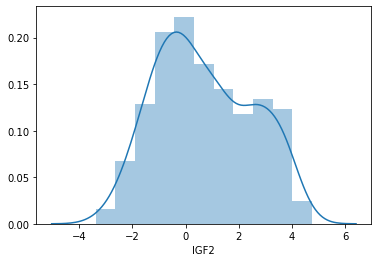

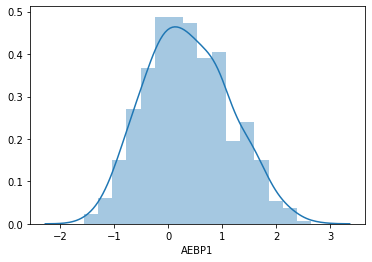

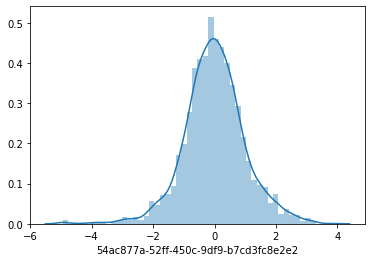

In [129]:
# plot 2 random gene distributions
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
sns.distplot(df_data_norm.iloc[200, :]); plt.show()

# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()

Now let's visualize expression of the most variable genes across the dataset with hierachical clustering and a heatmap.

/Users/nicolemoiseyev/opt/anaconda3/envs/TCGA/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


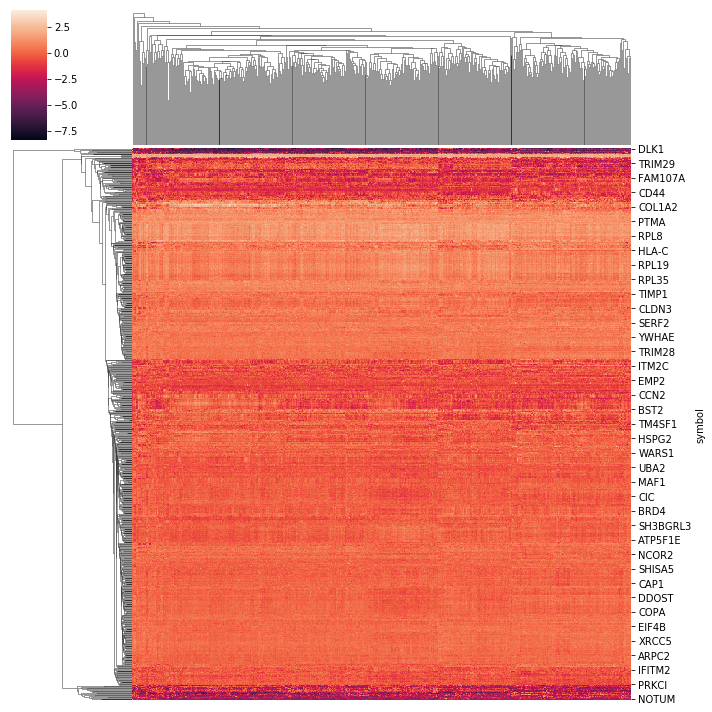

In [130]:
# Normalization
# take top 800 most variable rows

# the "i" in the variable here stands for "initial", since we'll do a different method 
# for selecting genes for a heatmap later
df_data_norm_heatmap_i = filter_by_var(df_data,top_n=800)

# compute log normalization of matrix
df_data_norm_heatmap_i = log2_normalize(df_data_norm_heatmap_i)

# convert to zscores
df_data_norm_heatmap_i = zscore_normalize(df_data_norm_heatmap_i) 

# Plot heatmap
ax = sns.clustermap(df_data_norm_heatmap_i,xticklabels=False)

We use PCA to initially reduce the dimensionality of the dataset before clustering while still maintaining most of the variability.

In [131]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "case_id"

display(df_data_norm_pca.head())

,PCA-0,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,...,PCA-496,PCA-497,PCA-498,PCA-499,PCA-500,PCA-501,PCA-502,PCA-503,PCA-504,PCA-505
case_id,,,,,,,,,,,,,,,,,,,,,
54ac877a-52ff-450c-9df9-b7cd3fc8e2e2,6.576452,-9.499549,-2.360587,16.045362,14.748195,7.064778,3.741233,-4.423464,0.024552,-1.694045,...,0.107673,0.015461,-0.235468,-0.037724,0.095216,0.153425,-0.059425,0.109823,0.016141,1.929359e-14
16e69011-c295-479f-b521-86e66fba498d,12.359834,-10.656531,14.107739,-7.225414,0.888790,7.616777,3.262293,4.613667,-0.463484,-3.465839,...,-0.289651,0.042406,-0.024412,-0.075737,-0.161350,-0.082166,-0.051547,-0.030314,0.039986,1.686672e-14
b60f22ac-a659-4f33-b01d-820e86a9a5c9,18.599178,-3.605265,0.263861,-2.335838,-0.552225,0.259635,-8.325312,-0.420494,-0.352570,4.721323,...,-0.036298,-0.258855,0.124703,0.063559,0.213949,-0.009092,-0.249995,0.172152,-0.002679,1.851427e-14
3bce9803-e74c-462e-bd40-8ec337a66f3a,10.849478,-0.470622,19.595375,2.464471,1.380150,-1.704869,1.412081,6.151327,8.360526,-1.722224,...,-0.274311,-0.150439,0.128735,0.084111,-0.014513,-0.201311,-0.142657,-0.029747,0.199073,1.794571e-14
1a094c2b-9fba-4bb1-929d-bb2cdf874bee,16.747894,3.113103,-6.192521,0.199203,8.830108,-0.922679,7.930652,2.722599,-3.738521,3.552068,...,0.068290,-0.005561,-0.149351,0.141525,0.003565,0.002432,0.068283,-0.168702,0.013094,1.829006e-14


In the two plots below (PCA and UMAP projections), datapoints are color-coded by the selected feature. The size of each point represents the number of reads for that sample.

In [93]:
pca_data = merge(
        df_data_norm_pca[["PCA-0", "PCA-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_pca["PCA-0"])*1.1, max(df_data_norm_pca["PCA-0"])*1.1],
    "y": [min(df_data_norm_pca["PCA-1"])*1.1, max(df_data_norm_pca["PCA-1"])*1.1]
}
    
scatter_plot(pca_data,"PCA-0", "PCA-1",axes,features)

We further reduce the dimensionality of the dataset using the UMAP (Uniform Manifold Approximation and Projection) technique on the data projected onto the first `n_pca_components` PCA components.

In [53]:
# UMAP
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=n_neighbors,
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-0', 'UMAP-1'],
  index=df_data_norm_pca.index,
)

In [54]:
# project data onto its first 2 UMAP components for visualization
umap_data = merge(
        df_data_norm_umap[["UMAP-0", "UMAP-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_umap["UMAP-0"])*1.1, max(df_data_norm_umap["UMAP-0"])*1.1],
    "y": [min(df_data_norm_umap["UMAP-1"])*1.1, max(df_data_norm_umap["UMAP-1"])*1.1]
}

scatter_plot(umap_data,"UMAP-0", "UMAP-1",axes,features)

We continue using the first 2 UMAP components.

To compute clusters, we use the Kmeans method, which requires us to define a total number of clusters. We test a range for the number of total clusters. 

For each number of clusters, we compute silhouette scores, which are a measure of how similar an entry is to its own cluster compared to other clusters. We want to maximize similarity within a cluster and differrences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

In [55]:
def plot_silhouette_analysis(n_clusters, data, cluster_labels, avg_score, sample_values, centers):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [56]:
silhouette_scores = []

max_clusters = math.ceil(df_data_norm_umap.shape[0]**0.5)


for n in range(2, max_clusters):
    X = df_data_norm_umap.values
    clusterer = KMeans(n_clusters=n, random_state=42)
    
    y_pred = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, y_pred, metric='cosine')
    
    # Compute a weighted score that rewards higher numbers of clusters
    weighted_score = silhouette_avg*0.6 + n/max_clusters*0.4
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y_pred)

    silhouette_scores.append({
        "N Clusters": n,
        "Silhouette Score": silhouette_avg,
        "Weighted Score": weighted_score
    })
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Plot the analysis for this number of clusters
    # plot_silhouette_analysis(n, X, y_pred, silhouette_avg, sample_silhouette_values, centers)


In [57]:
silhouette_scores = pd.DataFrame(silhouette_scores)
display(silhouette_scores.sort_values(["Silhouette Score", "Weighted Score"], ascending=False).reset_index().head())

best_score = silhouette_scores.sort_values('Silhouette Score').iloc[-1].to_dict()
best_weighted = silhouette_scores.sort_values('Weighted Score').iloc[-1].to_dict()

best = {"Silhouette Score": best_score, "Weighted Score": best_weighted}

,index,N Clusters,Silhouette Score,Weighted Score
0,1,3,0.990689,0.640568
1,2,4,0.984987,0.652531
2,0,2,0.953450,0.602839
3,3,5,0.485150,0.368013
4,8,10,0.138976,0.237232


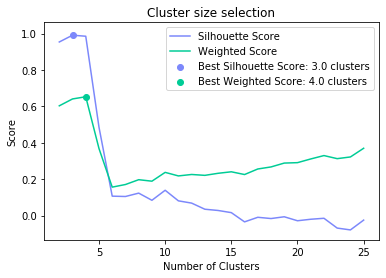

In [58]:
# plot both the uneqeighted and weighted scores as a function of # of clusters
colors = {"Silhouette Score": "#7C88FB", "Weighted Score": "#00CC96"}

for score_type in ['Silhouette Score', 'Weighted Score']:
    plt.plot(silhouette_scores['N Clusters'], silhouette_scores[score_type], label=score_type,color=colors[score_type])
    plt.scatter([best[score_type]['N Clusters']], [best[score_type][score_type]], label=f"Best {score_type}: {best[score_type]['N Clusters']} clusters",color=colors[score_type])
plt.legend()
plt.title('Cluster size selection')
plt.ylabel('Score')
plt.xlabel('Number of Clusters')
plt.show()

In [59]:
# Compute the Kmeans dataframe using the ideal number of clusters
km = KMeans(n_clusters=int(best['Weighted Score']['N Clusters']), random_state=42)
df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km.fit_predict(df_data_norm_umap.values)
]}, index=df_data_norm_umap.index)

print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Computed 4 clusters


Next, we compute differential expression for each cluster. We use the <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> for identifying differentially expressed genes among the different clusters.

In [60]:
# Get differential expression for each cluster
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm.loc[:, df_data_norm.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

display(df_diff_expr.head())

,Cluster 0 CD,Cluster 1 CD,Cluster 2 CD,Cluster 3 CD,Symbol
BMP7,-0.115023,0.102470,0.006632,0.004280,BMP7
IGFN1,-0.096421,0.030945,-0.010497,0.066520,IGFN1
AKR1B10,-0.092535,0.028128,-0.031512,0.085716,AKR1B10
REG1A,-0.091500,0.046272,0.036539,0.003985,REG1A
TCN1,-0.075606,-0.015764,-0.003347,0.082130,TCN1


We fit a logistic regression on each clinical feature to see which most accurately predict the cluster each datapoint falls into. We also plot up to 5 ROC curves for features that resulted in an AUC $\gt 0.7$. 

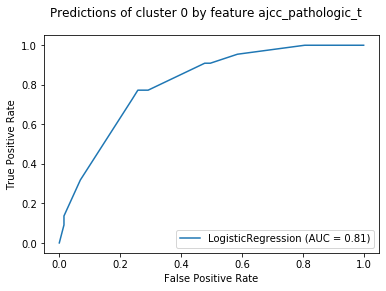

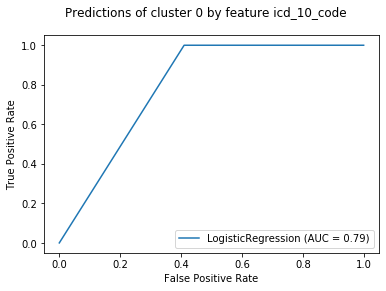

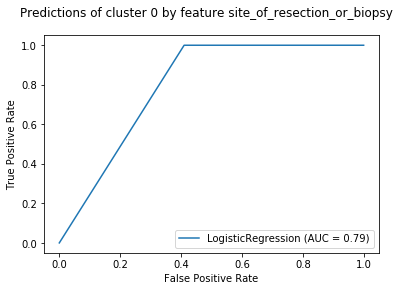

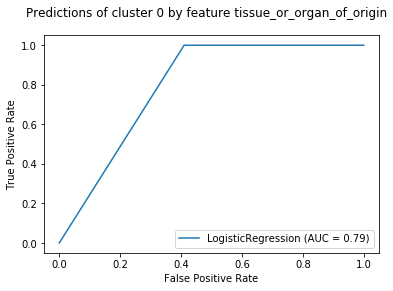

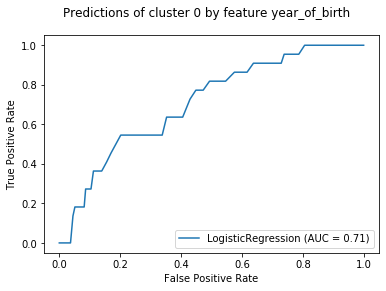

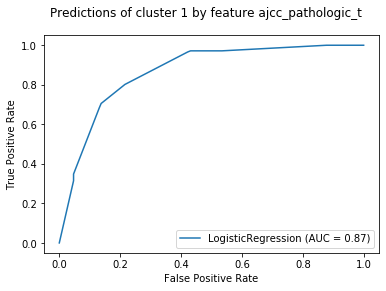

,0,1,2,3
Feature,,,,
prior_malignancy,0.515186,0.538027,0.526288,0.543263
ajcc_pathologic_t,0.807778,0.866417,0.692991,0.853686
year_of_death,0.469388,0.846525,0.425926,0.745298
race,0.641596,0.602390,0.637096,0.615378
synchronous_malignancy,0.525450,0.520383,0.517331,0.521562
ajcc_staging_system_edition,0.598243,0.537311,0.623969,0.540297
ethnicity,0.502747,0.527082,0.537477,0.521436
days_to_death,0.538462,0.465409,0.516379,0.490625
icd_10_code,0.794931,1.000000,0.974474,0.968293


In [61]:
# LR
aucs = {}
num_rocs_plotted = 0

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}

    for feature in features:
        lr = LogisticRegression()
        X = df_clinical.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)

        if (len(set(y_true)) < 2): continue # if we only have one class in the dataset
        lr.fit(X, y_true)

        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # plot a few good ROCs, but no more than 5
        if (auc_score > 0.7 and num_rocs_plotted < 6):
            fig = metrics.plot_roc_curve(lr, X, y_true)
            fig.figure_.suptitle(f'Predictions of cluster {cluster} by feature {feature}')
            plt.show()
            num_rocs_plotted += 1

df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Feature"
display(df_cluster_aucs.head(10))

Next we find the top most up and downregulated genes for each cluster, both to select which data to display in the heatmap below and for Enrichment analysis.

In [62]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_umap, right_on="case_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_pca, right_on="case_id")

In [63]:
# Get top Genes for each cluster
top_genes = {}
all_top_genes = []
heatmap_top_n = min(heatmap_top_n, top_n_genes_enrichment)
for cluster in df_clustered_umap['Cluster'].unique():
    cd_col = f'Cluster {cluster} CD'
    if cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    all_top_genes.append(up_genes[:heatmap_top_n])
    all_top_genes.append(dn_genes[:heatmap_top_n])
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
all_top_genes = [item for sublist in all_top_genes for item in sublist]  # flatten all genes to one list

We select data corresponding to only the `heatmap_top_n` up and downregulated genes for each cluster. We log-transform and normalize as before, plotting a heatmap for the results.

/Users/nicolemoiseyev/opt/anaconda3/envs/TCGA/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


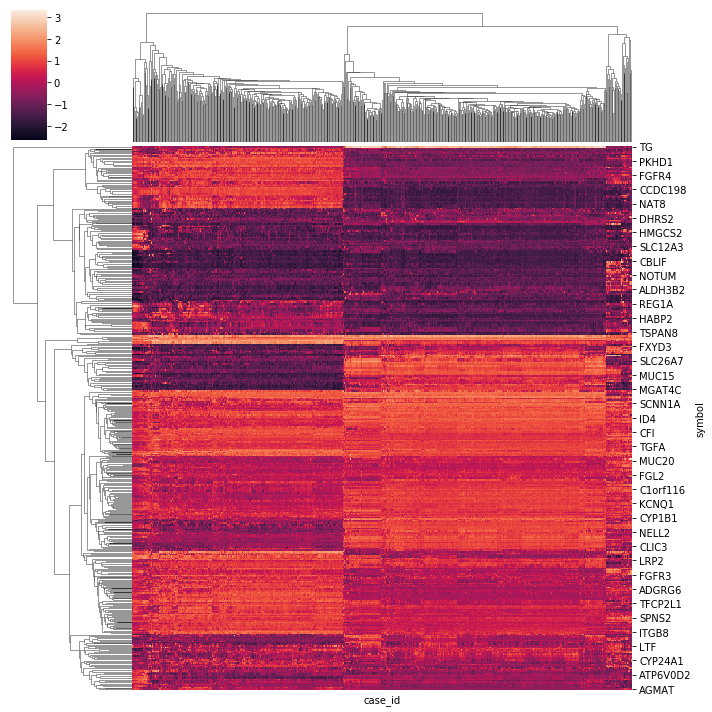

In [64]:
df_data_norm_heatmap_f = df_data.loc[all_top_genes, :]

# compute log normalization of matrix
df_data_norm_heatmap_f = log2_normalize(df_data_norm_heatmap_f)

# convert to zscores
df_data_norm_heatmap_f = zscore_normalize(df_data_norm_heatmap_f) 

# Plot heatmap
ax = sns.clustermap(df_data_norm_heatmap_f,xticklabels=False)

#  3. Load Enrichr Data  <a class="anchor" id="enrichr"></a>

We query the Enrichr API for enrichment analysis of the top most upregulated and downregulated genes for each cluster calculated above.

In [65]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

def save_enrichr_data(cancer_type,df_diff_expr,df_clustered_umap,df_all_results,df_cluster_aucs):
    output=f"appyter_data/{cancer_type}"
    os.makedirs(output, exist_ok=True)
    df_diff_expr.to_csv(
        f'{output}/df.tsv',
        sep='\t',
        index=None
    )
    df_clustered_umap.to_csv(
        f'{output}/df_umap.tsv',
        sep='\t',
        index=None
    )
    df_all_results.to_csv(
        f'{output}/df_enrich.tsv',
        sep='\t',
        index=None
    )
    df_cluster_aucs.to_csv(
        f'{output}/cluster_aucs.csv',
        sep='\t',
        index=None
    )

In [66]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        up_link = enrichr_link_from_genes(up_genes, f'cluster {cluster} up')
    else:
        print(f'cluster {cluster} up: empty')
    if dn_genes.size:
        dn_link = enrichr_link_from_genes(dn_genes, f'cluster {cluster} down')
    else:
        print(f'cluster {cluster} down: empty')
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_enrichr_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
        for category, libraries in enrichr_libraries.items():
            for library in libraries:
                try:
                    results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                    results['link'] = link['link']
                    results['library'] = library
                    results['category'] = category
                    results['direction'] = link_type
                    results['cluster'] = cluster
                    all_enrichr_results.append(results)
                except:
                    print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_enrichr_results = pd.concat(all_enrichr_results).reset_index()

In [67]:
# Display a dataframe with clickable enrichr links
df_clickable = df_enrichr_results.copy()
df_clickable['link'] = df_clickable["link"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_enrichr_results.to_csv(), 'Download Enrichr results', 'Enrichr results.csv')

,index,rank,term,pvalue,zscore,combinedscore,overlapping_genes,adjusted_pvalue,,,link,library,category,direction,cluster
0,0,1,anaplastic thyroid carcinoma UMLS CUI-C0238461 human GSE65144 sample 654,3.301569e-26,10.434783,612.238066,"[FCGBP, CALCA, CLIC3, PARM1, CXCR4, LRP2, CLU, C4A, GJA1, TPO, HHEX, HLA-DMB, IYD, ZBED2, EMB, METTL7A, MUC15, DSP, ANXA3, GPX3, DIO1, SORD, KCNJ16, NPNT, HOPX, TSHR, TG, FNDC1, ID4, C16ORF89, CPE, SLC26A7, SLC26A4, ATF3, FKBP5, MATN2]",2.770016e-23,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=3dbb40a8434a3fe80ce46af442e3b12d,Disease_Perturbations_from_GEO_down,Crowd,up,1
1,1,2,breast cancer DOID-1612 human GSE3744 sample 978,1.614404e-16,5.959368,216.696894,"[ITIH5, COL17A1, FCGBP, CFH, CITED1, FAM107A, VTCN1, OLFML2A, DMKN, CXCL14, RASD1, CAPN6, ENPP2, SH3BGRL2, IGFBP6, MUC15, KCNN4, FZD1, NTRK2, AFAP1L2, ANXA1, MME, EGF, ANXA3, GPX3, OLFM4, RBP4, ID4, C16ORF89, SLC27A6, GAS6, ATF3, MATN2]",6.772425e-14,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=3dbb40a8434a3fe80ce46af442e3b12d,Disease_Perturbations_from_GEO_down,Crowd,up,1
2,2,3,Breast Cancer C0006142 human GSE3744 sample 24,1.693786e-15,5.701559,193.920343,"[ITIH5, COL17A1, FCGBP, CFH, CITED1, VTCN1, OLFML2A, CLU, EDNRB, CAPN6, PDK4, ENPP2, SH3BGRL2, IGFBP6, FZD1, NTRK2, AFAP1L2, ANXA1, MME, EGF, ANXA3, GPX3, OLFM4, RBP4, AKR1B10, ID4, C16ORF89, SLC27A6, GAS6, ATF3, FKBP5, MATN2]",4.736955e-13,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=3dbb40a8434a3fe80ce46af442e3b12d,Disease_Perturbations_from_GEO_down,Crowd,up,1
3,3,4,Papillary Carcinoma of the Thyroid C0238463 human GSE3678 sample 306,4.766334e-15,7.123288,234.906074,"[FCGBP, BTG2, STC1, MT1X, LRP2, GJA1, TPO, IYD, ZBED2, INPP5J, PLEKHH1, AFAP1L2, GPX3, DIO1, DIO2, SORD, TSHR, TG, ID4, C16ORF89, SLC26A7, COL9A3, FMOD, SLC26A4, ATF3, MATN2]",9.997386e-13,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=3dbb40a8434a3fe80ce46af442e3b12d,Disease_Perturbations_from_GEO_down,Crowd,up,1
4,4,5,sporadic breast cancer DOID-8029 human GSE3744 sample 979,2.526509e-14,5.800000,181.594246,"[ITIH5, CLIC6, COL17A1, FCGBP, CFH, CITED1, STC1, LRP2, OLFML2A, CLU, CXCL14, C4A, ENPP2, SH3BGRL2, IGFBP6, NTRK2, AFAP1L2, ANXA1, MME, EGF, IGFBP4, GPX3, GFRA1, OLFM4, AKR1B10, C16ORF89, CPE, FMOD, MATN2]",4.239482e-12,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=3dbb40a8434a3fe80ce46af442e3b12d,Disease_Perturbations_from_GEO_down,Crowd,up,1
5,0,1,Spinal Muscular Atrophy C0026847 mouse GSE10599 sample 235,7.498225e-22,10.344828,503.195232,"[SLC44A4, TACSTD2, ACSM2A, SLC3A1, SLC5A12, KIF12, CLDN2, AQP3, PKHD1, DPP4, TSPAN8, HNF4A, SPP1, SOSTDC1, ATP6V0A4, GPC4, ITGB6, KCNJ1, HABP2, SLC17A3, NAPSA, SPINK1, HNF1B, PDZK1, PDZK1IP1, CHDH, ALDOB, RHCG, CDH16, ATP6V0D2]",6.291011e-19,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=59b29046d0b2131bb8c2c64d80f76ab3,Disease_Perturbations_from_GEO_down,Crowd,down,1
6,1,2,nephrosclerosis DOID-11664 human GSE20602 sample 905,4.204893e-17,9.174312,345.942182,"[SDC4, ACSM2A, GBA3, LAMP5, IMPA2, CAMK2N1, MYC, HMGCS2, HABP2, SLC17A3, PLS1, EGLN3, GPX2, GSTM1, MMP7, GDF15, PDZK1, BHMT, ELF3, SST, SDC1, SLC22A8, SLC29A1, CDH16, S100A9]",1.763952e-14,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=59b29046d0b2131bb8c2c64d80f76ab3,Disease_Perturbations_from_GEO_down,Crowd,down,1
7,2,3,nasopharynx carcinoma DOID-9261 human GSE12452 sample 775,5.367228e-16,6.434316,226.237318,"[PIGR, CALML5, PSCA, GDA, TMPRSS4, CXCL17, MSLN, AQP3, IMPA2, AGR2, GCNT3, PLS1, AKR1C3, AKR1C2, DHCR24, PDZK1IP1, CP, BACE2, BPIFB1, ELF3, CEACAM5, GSTA1, ALDH1A1, PRR15, S100P, RHCG, S100A9, S100A8, TNFRSF21, LTF]",1.501035e-13,0,0,https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=59b29046d0b2131bb8c2c64d80f76ab3,Disease_Perturbations_from_GEO_down,Crowd,down,1
8,3,4,Cancer of the Stomach C0024623 human GSE2685 sample 361,1.595833e-15,7.874016,268.278585,"[KRT20, NDRG1, C7, TSPAN8, CA2, QSOX1, HMGCS2, CYB5A, GPX2, SPINK1, AKR1C1, AKR1C3, RNASE1, PGC, MUC5AC, 


Cluster reference:


Enrichr results, by cluster:


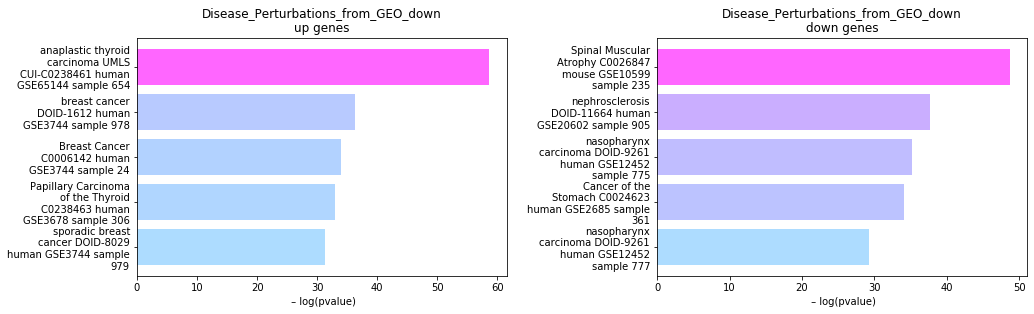

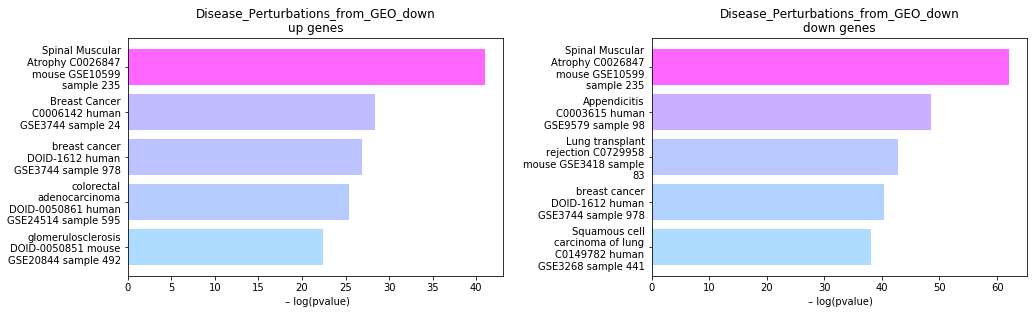

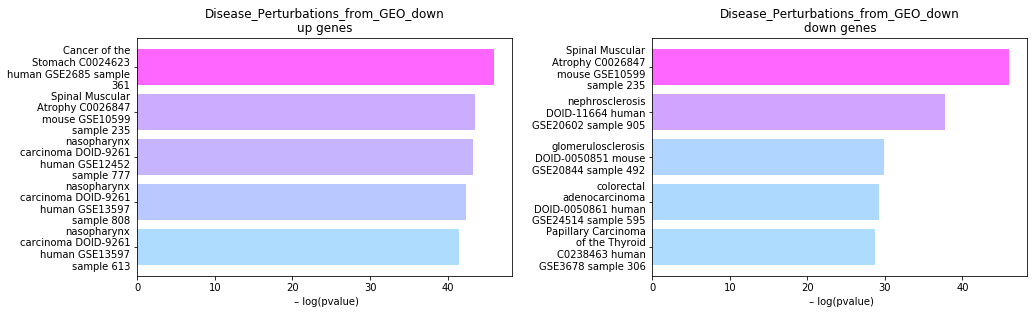

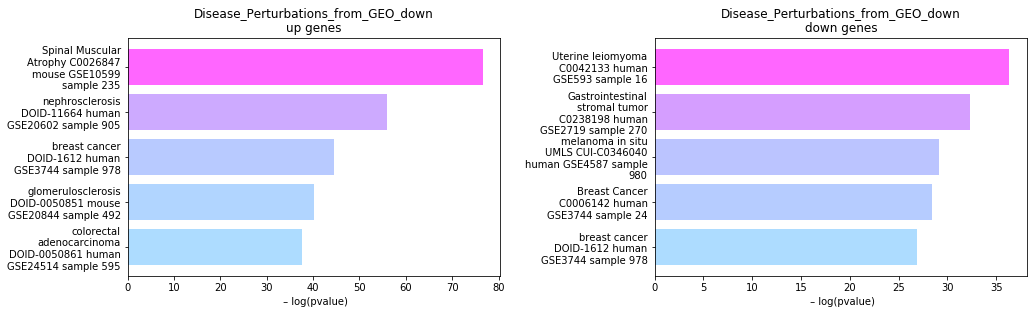

In [87]:
print("\nCluster reference:")
fig = px.scatter(
    df_clustered_umap,
    x = df_clustered_umap['UMAP-0'],
    y = df_clustered_umap['UMAP-1'],
    color = "Cluster",
)

fig.update_traces(marker=dict(
            size=12,
            opacity=0.8,
            line=dict(
                color='white',
                width=1
            )))
fig.show()

# Map each cluster to the automatic color it presents as in the scatter plot
clusters = df_clustered_umap["Cluster"].unique()
#plotly_colors = px.colors.qualitative.Plotly
plotly_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
cluster_colors = {}
i = 0
for c in clusters:
    cluster_colors[c] = plotly_colors[i]
    i += 1

def cluster_heading(cluster):
    display(HTML(f'''
    <div style='background-color:{cluster_colors[cluster] + '98'};
        width:50rem;max-width:100%;height:3rem;display:flex;align-items:center;
        justify-content:center;color:white;font-size:2rem'>
        <center>Cluster {cluster}</center>
    </div>'''))
    
print("Enrichr results, by cluster:")

# Make horizontal barplots to visualize top Enrichr results
clusters = df_enrichr_results["cluster"].unique()
for cluster in clusters:
    cluster_results = df_enrichr_results.loc[df_enrichr_results["cluster"] == cluster, :]
    libraries = cluster_results["library"].unique()
    num_rows = len(libraries)

    count = 1 # keep track of which subplot we're on
    fig = plt.figure(figsize=(15,5*num_rows))
    
    for library in cluster_results["library"].unique():
            library_results = cluster_results.loc[cluster_results["library"] == library, :]
            for direction in library_results["direction"].unique():
                plot_results = library_results.loc[cluster_results["direction"] == direction, :]
                plot_results = plot_results.sort_values("pvalue",ascending=False)
                labels = plot_results["term"]
                labels = [ '\n'.join(wrap(l, 20)) for l in labels ]
                values = plot_results["pvalue"]
                values = -np.log(values)
                
                # normalize values to map from 0-1 -> color, with opacity also based on normalized pvalue
                cmap = plt.get_cmap('cool')
                norm_values = [ 0.3 + (x - min(values))/(max(values) - min(values))*0.7 for x in values]
                colors = [ [*cmap(val)[:3], 0.4  + 0.2*val] for val in norm_values]
                
                # plot result
                ax = fig.add_subplot(num_rows,2,count)
                ax.barh(labels,values,color = colors)
                ax.set_title(f'{library}\n{direction} genes')
                ax.set_xlabel(' – log(pvalue)')
                count += 1
                
    cluster_heading(cluster)
    #title = plt.suptitle(f'Cluster {cluster}',fontsize=24, color="white",bbox=(dict(facecolor=cluster_colors[cluster], alpha=0.8,pad=5)))
    fig.tight_layout(pad=3, w_pad=2, h_pad=6)
    
    plt.show()

# 4. Load L1000 Data  <a class="anchor" id="l1000"></a>

We query the <a href="https://amp.pharm.mssm.edu/L1000FWD/" target="_blank">L1000 Fireworks Display</a> (L1000FWD) API to find the most similar and most dissimilar RNA-seq signatures from the L1000 database for each cluster based on the up and down genes. We also link to the L1000FWD interactive projection of those results for each cluster.

In [84]:
# Util functions
def l1000fwd_results_from_genes(up_genes, down_genes, description='', l100fwd_link='http://amp.pharm.mssm.edu/L1000FWD/'):
    ''' Functional access to L1000FWD API
    '''
    import time
    time.sleep(1)
    response = requests.post(l100fwd_link + 'sig_search', json={
    'up_genes': list(up_genes),
    'down_genes': list(down_genes),
    })
    l1000fwd_results =  {}
    if response.status_code != 200:
        raise Exception('L1000FWD failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    if 'KeyError' in response.text:
        l1000fwd_results['result_url'] = None
    else:
        # Get ID and URL
        result_id = response.json()['result_id']
        l1000fwd_results['result_url'] = 'https://amp.pharm.mssm.edu/l1000fwd/vanilla/result/'+result_id
        l1000fwd_results['result_id'] = result_id

        # Get Top
        l1000fwd_results['signatures'] = requests.get(l100fwd_link + 'result/topn/' + result_id).json()

    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    return l1000fwd_results

def l1000fwd_sig_link(sig_id):
    return 'https://amp.pharm.mssm.edu/dmoa/sig/' + sig_id

def get_signature_by_id(sig_id):
    response = requests.get("http://amp.pharm.mssm.edu/L1000FWD/sig/" + sig_id)
    if response.status_code != 200:
        raise Exception('L1000FWD signature query  failed with status {}: {}'.format(
          response.status_code,
          response.text,
        ))
    return response.json()

In [92]:
def display_l1000fwd_results(l1000fwd_results, plot_counter,cluster_id,nr_drugs=7, height=300):
    # Check if results
    if l1000fwd_results['result_url']:

        # Display cluster title
        display(HTML('<br><br>'))
        cluster_heading(cluster)

        # Display IFrae
        display(HTML(f"<a href='{l1000fwd_results['result_url']}' target='_blank'> View L1000FWD for cluster {cluster_id}</a>"))
    
        # Display tables
        for direction, signature_list in l1000fwd_results['signatures'].items():

            # Fix dataframe
            rename_dict = {'sig_id': 'Signature ID', 'pvals': 'P-value', 'qvals': 'FDR', 'zscores': 'Z-score', 'combined_scores': 'Combined Score'}
            signature_dataframe = pd.DataFrame(signature_list)[list(rename_dict.keys())].rename(columns=rename_dict).sort_values('P-value').rename_axis('Rank')
            signature_dataframe.index = [x + 1 for x in range(len(signature_dataframe.index))]
            signature_csv = signature_dataframe.to_csv(sep=",")

            # Display table
            pd.set_option('max.colwidth', None)
            signature_dataframe['Signature ID'] = [f'<a href={l1000fwd_sig_link(x)} target="_blank">{x}</a>' for x in signature_dataframe['Signature ID']]
            table_html = signature_dataframe.to_html(escape=False, classes='w-100')
            display(HTML(f'<h3>{direction.title()} Signatures: </h3>'))
            display(HTML(f'<style>.w-100{{width: 100% !important;}}</style><div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))

            # Display download button
            download_button(signature_csv, f'Download {direction.title()} Signatures', f'Cluster {cluster_id} L1000FWD {direction.title()} signatures.csv')
        # Link
        display(HTML('Full results available at: <a href="{result_url}" target="_blank">{result_url}</a>.'.format(**l1000fwd_results)))
        
    # Display error
    else:
        display(Markdown('### No results were found.\n This is likely due to the fact that the gene identifiers were not recognized by L1000FWD. Please note that L1000FWD currently only supports HGNC gene symbols (https://www.genenames.org/). If your dataset uses other gene identifier systems, such as Ensembl IDs or Entrez IDs, consider converting them to HGNC. Automated gene identifier conversion is currently under development.'))


In [ ]:
plot_counter = 0
all_l1000fwd_results = {}
for cluster, (up_genes, dn_genes) in top_genes.items():
    results = l1000fwd_results_from_genes(up_genes,dn_genes)
    all_l1000fwd_results[cluster] = results
    display_l1000fwd_results(results,plot_counter,cluster)
    plot_counter += 1

,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC007_A549_24H:BRD-K22546959-001-05-1:10,3.321741e-19,3.555010e-15,-1.641147,30.326161
2,CPC008_HT29_6H:BRD-K37456065-001-01-6:10,2.196033e-18,1.342999e-14,-1.718277,30.341965
3,CPC004_HT29_6H:BRD-K03670461-001-02-0:10,1.236003e-17,5.879116e-14,-1.645579,27.823410
4,CPC014_HEPG2_6H:BRD-K78062244-001-06-5:10,2.888730e-17,1.124215e-13,-1.712270,28.319729
5,CPC015_HT29_6H:BRD-K76805682-001-05-0:10,7.812650e-17,2.572706e-13,-1.754108,28.253779
6,CPC016_MCF7_6H:BRD-K31238592-001-01-6:10,1.439923e-16,4.109445e-13,-1.775290,28.123543
7,CVD001_HEPG2_6H:BRD-K26997899-001-01-4:10,1.988611e-16,5.320653e-13,-1.831981,28.764764
8,CPC013_PC3_24H:BRD-K23984367-075-05-3:10,4.430015e-15,6.539466e-12,-1.713356,24.592822
9,CPC014_HT29_6H:BRD-K79404599-001-03-6:10,4.817974e-13,3.819494e-10,-1.706129,21.014618
10,CPC004_VCAP_24H:BRD-K43290182-001-01-9:10,1.725291e-12,1.191258e-09,-1.671760,19.665147


,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC012_PC3_6H:BRD-K86269644-001-01-3:10,1.932771e-19,2.758000e-15,1.759563,-32.928146
2,CPC014_MCF7_6H:BRD-A93893742-001-07-1:10,1.694800e-18,1.209211e-14,1.746787,-31.041950
3,CPC007_A549_6H:BRD-A24021119-001-06-0:10,3.339238e-18,1.786868e-14,1.831815,-32.013447
4,CPC014_MCF7_6H:BRD-K67258146-001-01-2:10,2.011777e-17,8.612215e-14,1.821849,-30.418361
5,CPC019_MCF7_24H:BRD-K48803730-001-01-1:10,1.026653e-16,3.139284e-13,1.651103,-26.398781
6,CPC019_PC3_24H:BRD-K10649245-001-01-0:10,5.840401e-16,1.250109e-12,1.702588,-25.936472
7,CPC003_PC3_24H:BRD-K72462751-001-01-9:10,8.143381e-16,1.660048e-12,1.831627,-27.637773
8,CPC006_JHUEM2_6H:BRD-K53903639-001-01-3:80,9.419352e-16,1.832877e-12,1.758336,-26.420724
9,CPC014_HT29_6H:BRD-K77008974-001-01-6:10,2.344209e-15,4.014130e-12,1.728467,-25.287485
10,CPC006_HCC515_6H:BRD-K67844266-001-01-3:11.1,2.500650e-15,4.117321e-12,1.801416,-26.304174


,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC009_PC3_24H:BRD-K42489623-001-06-4:10,1.142009e-18,4.888825e-14,-1.700857,30.517332
2,CPC012_ASC_24H:BRD-K02223034-001-01-9:10,1.429356e-17,8.741330e-14,-1.727942,29.106935
3,CPC007_HT29_6H:BRD-K22210218-001-04-4:10,1.668344e-15,5.101438e-12,-1.680217,24.829760
4,CPC006_HT29_24H:BRD-A13084692-001-04-1:10,4.206468e-15,1.059263e-11,-1.679888,24.150205
5,PCLB003_HCC515_24H:BRD-K04218075-048-12-5:10,1.634373e-14,3.114249e-11,-1.853247,25.550060
6,CPC018_A375_6H:BRD-K34092021-001-02-3:10,2.385638e-14,3.782473e-11,-1.791331,24.402215
7,CPC001_VCAP_24H:BRD-A22707317-001-02-5:10,2.570921e-14,3.930663e-11,-1.618431,21.994336
8,CPC006_HCC515_6H:BRD-K61829047-001-01-6:10,1.912336e-13,1.949171e-10,-1.716115,21.826302
9,CPC005_MCF7_6H:BRD-K40624912-003-02-3:10,3.174738e-13,2.954508e-10,-1.672785,20.906962
10,CPC008_PC3_24H:BRD-K66037923-001-04-4:10,5.312595e-13,4.641365e-10,-1.686676,20.703428


,Signature ID,P-value,FDR,Z-score,Combined Score
1,CPC012_SKB_24H:BRD-K26818574-001-03-0:10,1.745941e-14,3.114249e-11,1.802277,-24.795677
2,CPC014_HT29_6H:BRD-K95901403-001-01-1:10,1.518888e-12,1.140738e-09,1.749248,-20.673438
3,CPC007_HT29_6H:BRD-A69470004-019-04-0:10,1.913314e-12,1.388255e-09,1.779714,-20.855073
4,CPC012_VCAP_6H:BRD-K25731886-001-01-3:10,2.848300e-12,1.966659e-09,1.745872,-20.156814
5,CPC005_VCAP_24H:BRD-A99164655-003-01-5:10,3.981765e-12,2.622390e-09,1.813563,-20.674483
6,CPC006_HCC515_24H:BRD-K05649647-001-03-7:20,5.536170e-12,3.398499e-09,1.797948,-20.239122
7,CPC007_HA1E_24H:BRD-K73610817-001-06-3:10,6.602890e-12,3.670950e-09,1.789528,-20.007398
8,CPC007_A549_24H:BRD-K73610817-001-06-3:10,9.993091e-12,5.092789e-09,1.763535,-19.399409
9,CPC014_VCAP_6H:BRD-K97764662-001-09-0:10,1.348024e-11,6.302734e-09,1.737637,-18.888642
10,CPC019_A375_6H:BRD-K35024477-001-01-6:10,4.057673e-11,1.593623e-08,1.707701,-17.745954


Based on the signatures most "opposite" to the profile of a given cluster (i.e. up and down genes are reversed), we can obtain a set of drugs that may "perturb" that cluster into the healthy direction by upregulating its downregulated genes and downregulating the upregulated genes. These may present effective treatments for patients belonging to that cluster.

In [ ]:
df_drugs = pd.read_csv("https://amp.pharm.mssm.edu/l1000fwd/download/Drugs_metadata.csv")

# Load top drug suggestions for each cluster based on the drugs used to produce the top_n_drugs opposite signatures
drug_results = {}
for cluster, results in all_l1000fwd_results.items():
    opposite_sigs = results["signatures"]["opposite"][:top_n_drugs]
    sig_ids = [sig["sig_id"] for sig in opposite_sigs]
    pert_ids = []
    for sig_id in sig_ids:
        signature = get_signature_by_id(sig_id)
        pert_ids.append(signature["pert_id"])
    
    df_cluster_drugs = df_drugs[df_drugs["pert_id"].isin(pert_ids)].copy()
    df_cluster_drugs["cluster"] = cluster
    df_cluster_drugs = df_cluster_drugs[["cluster", *list(filter(lambda x: x!="cluster", df_cluster_drugs.columns))]]
    drug_results[cluster] = df_cluster_drugs
    
df_all_drugs = pd.concat(drug_results).reset_index()

In [ ]:
# Display a dataframe with clickable L1000FWD links
df_clickable = df_all_drugs.copy()
df_clickable['pert_url'] = df_clickable["pert_url"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_all_drugs.to_csv(), 'Download L1000FWD drug results', 'L1000FWD drugs.csv')

In [120]:
# Sample values to run the notebook locally

data_filename = ''''''''
clinical_data_filename = ''''''''
cancer = '''Serous cystadenocarcinoma, NOS'''
n_pca_components = 10
n_neighbors = 40
min_cluster_dist = 0.3
top_n_genes = 2500
top_n_genes_enrichment = 250
heatmap_top_n = 100
top_n_results = 5
use_default_libraries = False
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
cell_types_libraries = []
miscellaneous_libraries = []
legacy_libraries = []
crowd_libraries = []
top_n_drugs = 5
